## Setup

In [1]:
import pandas as pd
patient_history=pd.read_csv('./vaccine reaction/2021VAERSDATA.CSV', sep=',', encoding='ISO-8859-1')
patient_sympt=pd.read_csv('./vaccine reaction/2021VAERSSYMPTOMS.CSV', sep=',',encoding='ISO-8859-1')
patient_vac=pd.read_csv('./vaccine reaction/2021VAERSVAX.CSV', sep=',',encoding='ISO-8859-1')

C:\Users\zelon\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
pd.set_option("display.max_rows", 1000)

In [3]:
patient_history

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy"""
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34116,1113917,03/19/2021,FL,88.0,87.0,NaN,F,NaN,throat closure three weeks after second dose; ...,NaN,...,NaN,Medical History/Concurrent Conditions: Aortic ...,NaN,"USMODERNATX, INC.MOD20210",2,03/12/2021,NaN,NaN,Y,NaN
34117,1113920,03/19/2021,PA,83.0,NaN,NaN,F,NaN,positive COVID-19 test with no symptoms; Asymp...,NaN,...,NaN,Medical History/Concurrent Conditions: Atrial ...,NaN,USPFIZER INC2021231682,2,03/16/2021,NaN,Y,NaN,NaN
34118,1113963,03/19/2021,MS,59.0,NaN,NaN,F,NaN,HLH (hemophagocyticlymphohistiocytosis); This ...,Y,...,NaN,Medical History/Concurrent Conditions: Type II...,NaN,USPFIZER INC2021257356,2,03/12/2021,NaN,NaN,NaN,NaN
34119,1115045,03/19/2021,AZ,57.0,NaN,NaN,M,NaN,Death; A spontaneous report was received from ...,Y,...,NaN,Medical History/Concurrent Conditions: No adve...,NaN,"USMODERNATX, INC.MOD20210",2,03/15/2021,NaN,NaN,NaN,NaN


## Data preprocessing

In [4]:
 # get the needed columns from patient history file
patient_history=patient_history.loc[: , ['VAERS_ID','AGE_YRS','SEX','CUR_ILL','HISTORY','ALLERGIES']]
 # get the needed columns from patient vaccine file
patient_vac=patient_vac.loc[:,['VAERS_ID','VAX_NAME']]
 # commbining reactions per patient 
patient_sympt['SYMPTOMS']= patient_sympt['SYMPTOM1'].fillna('')+','+ patient_sympt['SYMPTOM2'].fillna('')+','+ patient_sympt['SYMPTOM3'].fillna('')+','+ patient_sympt['SYMPTOM4'].fillna('')+','+ patient_sympt['SYMPTOM5'].fillna('')
patient_sympt=patient_sympt.groupby(by='VAERS_ID')['SYMPTOMS'].agg(lambda x: ','.join(x)).reset_index()


In [5]:
 # mergeing all extracted info above to a single dataframe 
#df=pd.merge(patient_history, patient_vac, left_on='VAERS_ID', right_on='VAERS_ID')
df=patient_history.merge( patient_vac , on='VAERS_ID')


In [6]:
df=pd.merge(df, patient_sympt,  left_on='VAERS_ID', right_on='VAERS_ID')
df=df.fillna(value="")
# prepare y values step1 
# make symptom columns into a list 
df['SYMPTOMS']=df['SYMPTOMS'].apply(lambda x : x.split(","))
# and than remove any empty values in the list. 
df['SYMPTOMS']=df['SYMPTOMS'].apply(lambda x : [i for i in x if i])
df=df.drop_duplicates(['VAERS_ID'])
df[df['VAERS_ID']==1015465]

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS
22431,1015465,75.0,F,U07.1 2019-nCoV acute respiratory disease (Pri...,U07.1 2019-nCoV acute respiratory disease (Pri...,"Iodinated Contrast- Oral and IV Dye, Penicilli...",COVID19 (COVID19 (MODERNA)),"[Heart rate abnormal, Pulse absent, Respirator..."


In [7]:
def convertAge(string_age):
    if string_age =="" :
        return "unknown_age"
    if 0 <= float(string_age)<=2:
        return "0TO2yr"
    if 3 <= float(string_age)<=12:
        return "3TO12yr"
    if 13 <= float(string_age)<=19:
        return "13TO19yr"
    if 20 <= float(string_age)<=39:
        return "20TO39yr"
    if 40 <= float(string_age)<=59:
        return "40TO59yr"
    return "over60yr"

def gender(string):
    if string == "M":
        return 'male'
    if string == "F":
        return 'female'
    if string == "U":
        return 'unisex'
        

def changeVaxName(vax_name):
    if 'MODERNA'in vax_name:
        return 'MODERNA'
    if 'PFIZER' in vax_name:
        return 'PFIZER'
    
    return 'JANSSEN'

In [8]:
# remove none coivd related vaccine samples 
df=df[df['VAX_NAME'].str.contains('|'.join(['MODERNA','PFIZER-BIONTECH'])) & df['VAX_NAME'].isna()==False]
# put age in bucket under 60 or over
df['AGE_CAT']=df['AGE_YRS'].apply(lambda x : convertAge(x) )
# simmplify vaccine names 
df['VAX_NAME']=df['VAX_NAME'].apply(lambda x : changeVaxName(x))
df['SEX'] = df['SEX'].apply(lambda x :gender(x) )

df

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT
0,916600,33.0,female,None,None,Pcn and bee venom,MODERNA,"[Dysphagia, Epiglottitis]",20TO39yr
1,916601,73.0,female,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,"""Dairy""",MODERNA,"[Anxiety, Dyspnoea]",over60yr
2,916602,23.0,female,None,None,Shellfish,PFIZER,"[Chest discomfort, Dysphagia, Pain in extremit...",20TO39yr
3,916603,58.0,female,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","Diclofenac, novacaine, lidocaine, pickles, tom...",MODERNA,"[Dizziness, Fatigue, Mobility decreased]",40TO59yr
4,916604,47.0,female,Na,,Na,MODERNA,"[Injection site erythema, Injection site pruri...",40TO59yr
...,...,...,...,...,...,...,...,...,...
34625,1113917,88.0,female,,Medical History/Concurrent Conditions: Aortic ...,,MODERNA,"[Dysphagia, Hernia, Obstruction]",over60yr
34626,1113920,83.0,female,,Medical History/Concurrent Conditions: Atrial ...,,PFIZER,"[Arrhythmia, Asymptomatic COVID-19, Chills, Co...",over60yr
34627,1113963,59.0,female,,Medical History/Concurrent Conditions: Type II...,,PFIZER,"[Haemophagocytic lymphohistiocytosis, SARS-CoV...",40TO59yr
34628,1115045,57.0,male,,Medical History/Concurrent Conditions: No adve...,,MODERNA,[Death],40TO59yr


In [9]:
# Create a list of remove words
remove_word_list = ['none', 'na','nkda','nka','unknown']

def remove_words(strings):
    for words in remove_word_list:
        strings = strings.replace(words, '')
    return strings

In [10]:
# make the health_condition text lower case
df['CUR_ILL'] = df['CUR_ILL'].str.lower()
df['HISTORY'] = df['HISTORY'].str.lower()
df['ALLERGIES'] = df['ALLERGIES'].str.lower()
# remove list of words from columns

df['CUR_ILL'] = df['CUR_ILL'].apply(lambda x: remove_words(x))
df['HISTORY'] = df['HISTORY'].apply(lambda x: remove_words(x))
df['ALLERGIES'] = df['ALLERGIES'].apply(lambda x: remove_words(x))

In [11]:
df

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT
0,916600,33.0,female,,,pcn and bee venom,MODERNA,"[Dysphagia, Epiglottitis]",20TO39yr
1,916601,73.0,female,patient residing at nursing facility. see pati...,patient residing at nursing facility. see pati...,"""dairy""",MODERNA,"[Anxiety, Dyspnoea]",over60yr
2,916602,23.0,female,,,shellfish,PFIZER,"[Chest discomfort, Dysphagia, Pain in extremit...",20TO39yr
3,916603,58.0,female,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","diclofec, novacaine, lidocaine, pickles, tomat...",MODERNA,"[Dizziness, Fatigue, Mobility decreased]",40TO59yr
4,916604,47.0,female,,,,MODERNA,"[Injection site erythema, Injection site pruri...",40TO59yr
...,...,...,...,...,...,...,...,...,...
34625,1113917,88.0,female,,medical history/concurrent conditions: aortic ...,,MODERNA,"[Dysphagia, Hernia, Obstruction]",over60yr
34626,1113920,83.0,female,,medical history/concurrent conditions: atrial ...,,PFIZER,"[Arrhythmia, Asymptomatic COVID-19, Chills, Co...",over60yr
34627,1113963,59.0,female,,medical history/concurrent conditions: type ii...,,PFIZER,"[Haemophagocytic lymphohistiocytosis, SARS-CoV...",40TO59yr
34628,1115045,57.0,male,,medical history/concurrent conditions: no adve...,,MODERNA,[Death],40TO59yr


## Extract the needed columns for training

In [12]:
df_training = df.loc[:, ['AGE_CAT','SEX','VAX_NAME']]
# combining patients' current illness , medical history and, allergies and store in the "health condition column"
df['HEALTH_CONDITION'] = df['CUR_ILL']+","+ df['HISTORY']+","+df['ALLERGIES']


## NLTK PREPROCESSING

In [13]:
import nltk
import itertools
from string import punctuation
from nltk.corpus import stopwords

punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
df

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT,HEALTH_CONDITION
0,916600,33.0,female,,,pcn and bee venom,MODERNA,"[Dysphagia, Epiglottitis]",20TO39yr,",,pcn and bee venom"
1,916601,73.0,female,patient residing at nursing facility. see pati...,patient residing at nursing facility. see pati...,"""dairy""",MODERNA,"[Anxiety, Dyspnoea]",over60yr,patient residing at nursing facility. see pati...
2,916602,23.0,female,,,shellfish,PFIZER,"[Chest discomfort, Dysphagia, Pain in extremit...",20TO39yr,",,shellfish"
3,916603,58.0,female,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","diclofec, novacaine, lidocaine, pickles, tomat...",MODERNA,"[Dizziness, Fatigue, Mobility decreased]",40TO59yr,"kidney infection,diverticulitis, mitral valve ..."
4,916604,47.0,female,,,,MODERNA,"[Injection site erythema, Injection site pruri...",40TO59yr,",,"
...,...,...,...,...,...,...,...,...,...,...
34625,1113917,88.0,female,,medical history/concurrent conditions: aortic ...,,MODERNA,"[Dysphagia, Hernia, Obstruction]",over60yr,",medical history/concurrent conditions: aortic..."
34626,1113920,83.0,female,,medical history/concurrent conditions: atrial ...,,PFIZER,"[Arrhythmia, Asymptomatic COVID-19, Chills, Co...",over60yr,",medical history/concurrent conditions: atrial..."
34627,1113963,59.0,female,,medical history/concurrent conditions: type ii...,,PFIZER,"[Haemophagocytic lymphohistiocytosis, SARS-CoV...",40TO59yr,",medical history/concurrent conditions: type i..."
34628,1115045,57.0,male,,medical history/concurrent conditions: no adve...,,MODERNA,[Death],40TO59yr,",medical history/concurrent conditions: no adv..."


In [15]:
stopwords = stopwords.words('english')


In [16]:
def remove_words_containning_numbers(word):
    if word.isalpha():
        return word
    return ""
    

In [17]:
# tokenize df_training['HEALTH_CONDITION']
df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x : nltk.word_tokenize(x))
allwords=set(itertools.chain.from_iterable(df.HEALTH_CONDITION))
len(allwords)



16369

In [18]:
# remove any punctuations from words 
df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x : [''.join(c for c in s if c not in punctuation) for s in x])
allwords=set(itertools.chain.from_iterable(df.HEALTH_CONDITION))
len(allwords)

14288

In [19]:
from textblob import TextBlob
def spell_correct (word):
    return str(TextBlob(word).correct())
    

In [20]:
# remove any words mix with number
df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x : [remove_words_containning_numbers(w) for w in x])
allwords=set(itertools.chain.from_iterable(df.HEALTH_CONDITION))
len(allwords)

11954

In [21]:
# remove any empty words
df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x : [string for string in x if string != ""])
allwords=set(itertools.chain.from_iterable(df.HEALTH_CONDITION))
len(allwords)

11953

In [22]:
# remove stop words
df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x: [words for words in x if words not in stopwords])
allwords=set(itertools.chain.from_iterable(df.HEALTH_CONDITION))
len(allwords)

11822

In [23]:
meaningless=['aat',	'ab',	'abd',	'able',	'ac',	'ace',	'act',	'add',	'adh',	'adl',	'adm',	'af',	'afi',	'agar',	'age',	'ago',	'ahd',	'aid',	'aka',	'al',	'alexa',	'alf',	'all',	'alla',	'almost',	'alone',	'along',	'alpha',	'also',	'alt',	'although',	'always',	'am',	'amanda',	'ami',	'and',	'ang',	'anyone',	'apr',	'arb',	'arc',	'art',	'asa',	'ash',	'ask',	'ast',	'atb',	'ate',	'atm',	'attend',	'au',	'av',	'avg',	'b',	'ba',	'bad',	'bag',	'bav',	'bbb',	'bcc',	'be',	'bed',	'bee',	'bhp',	'bi',	'bl',	'bm',	'bp',	'br',	'brazil',	'c',	'ca',	'cb',	'cbc',	'cc',	'cd',	'cf',	'ch',	'chg',	'ci',	'ck',	'cl',	'cm',	'co',	'cor',	'cp',	'cr',	'crt',	'cry',	'ct',	'cta',	'cv',	'd',	'dad',	'day',	'ddd',	'de',	'dec',	'dl',	'dm',	'dmy',	'dnr',	'do',	'dt',	'dur',	'dx',	'dz',	'e',	'eat',	'ed',	'edd',	'ef',	'eg',	'em',	'er',	'et',	'eta',	'etc',	'eth',	'ez',	'f',	'fa',	'far',	'fix',	'fluent',	'fm',	'fourth',	'fr',	'friday',	'fu',	'fx',	'g',	'ga',	'gad',	'gb',	'ger',	'get',	'gg',	'gi',	'gl',	'gm',	'go',	'h',	'ha',	'hay',	'hc',	'hd',	'hep',	'hi',	'hl',	'ho',	'hop',	'hp',	'hr',	'hx',	'ic',	'id',	'ie',	'if',	'ii',	'iii',	'il',	'ill',	'inh',	'ink',	'inn',	'ip',	'ipp',	'iq',	'it',	'iv',	'ivi',	'j',	'jan',	'k',	'kg',	'l',	'la',	'lad',	'lb',	'le',	'll',	'lt',	'lv',	'm',	'ma',	'may',	'md',	'mg',	'mi',	'mm',	'mo',	'mr',	'mu',	'mw',	'n',	'na',	'nan',	'nc',	'nd',	'new',	'nh',	'nk',	'nl',	'no',	'non',	'nov',	'np',	'nt',	'nv',	'o',	'oa',	'oc',	'od',	'odd',	'op',	'ou',	'out',	'p',	'pa',	'pc',	'pe',	'pm',	'pn',	'po',	'pp',	'pr',	'pt',	'qt',	'r',	'ra',	'really',	'ro',	'rt',	's',	'sa',	'sh',	'so',	'sp',	'sr',	'ss',	'st',	'sx',	'tb',	'td',	'th',	'thing',	'ti',	'title',	'tm',	'tn',	'today',	'tu',	'tx',	'u',	'ua',	'un',	'up',	'upper',	'url',	'us',	'use',	'usual',	'v',	'va',	'vk',	'vp',	'vt',	'w',	'water',	'wc',	'while',	'white',	'wo',	'would',	'x',	'xl',	'xt',	'yo',	'yr',	'z',	'aaa']

df['HEALTH_CONDITION']= df['HEALTH_CONDITION'].apply(lambda x : [word for word in x if word not in meaningless])


In [24]:
df

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT,HEALTH_CONDITION
0,916600,33.0,female,,,pcn and bee venom,MODERNA,"[Dysphagia, Epiglottitis]",20TO39yr,"[pcn, venom]"
1,916601,73.0,female,patient residing at nursing facility. see pati...,patient residing at nursing facility. see pati...,"""dairy""",MODERNA,"[Anxiety, Dyspnoea]",over60yr,"[patient, residing, nursing, facility, see, pa..."
2,916602,23.0,female,,,shellfish,PFIZER,"[Chest discomfort, Dysphagia, Pain in extremit...",20TO39yr,[shellfish]
3,916603,58.0,female,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","diclofec, novacaine, lidocaine, pickles, tomat...",MODERNA,"[Dizziness, Fatigue, Mobility decreased]",40TO59yr,"[kidney, infection, diverticulitis, mitral, va..."
4,916604,47.0,female,,,,MODERNA,"[Injection site erythema, Injection site pruri...",40TO59yr,[]
...,...,...,...,...,...,...,...,...,...,...
34625,1113917,88.0,female,,medical history/concurrent conditions: aortic ...,,MODERNA,"[Dysphagia, Hernia, Obstruction]",over60yr,"[medical, historyconcurrent, conditions, aorti..."
34626,1113920,83.0,female,,medical history/concurrent conditions: atrial ...,,PFIZER,"[Arrhythmia, Asymptomatic COVID-19, Chills, Co...",over60yr,"[medical, historyconcurrent, conditions, atria..."
34627,1113963,59.0,female,,medical history/concurrent conditions: type ii...,,PFIZER,"[Haemophagocytic lymphohistiocytosis, SARS-CoV...",40TO59yr,"[medical, historyconcurrent, conditions, type,..."
34628,1115045,57.0,male,,medical history/concurrent conditions: no adve...,,MODERNA,[Death],40TO59yr,"[medical, historyconcurrent, conditions, adver..."


## auto correct spelling errors (run paralle), since it takes a long time to run, I saved the data processed dataframe
import multiprocessing
from autocorrect import Speller
import time
spell = Speller(lang='en')


import mypack.correc as co
import numpy as np
new_dff=df.loc[:,'HEALTH_CONDITION']
new_dff
start_time = time.time()
pool = multiprocessing.Pool(multiprocessing.cpu_count())

new_dff=new_dff.apply(lambda x :  pool.map(co.correction, x ))
   
print("--- %s seconds ---" % (time.time() - start_time))

In [101]:
#new_df=pd.read_csv('savedf4-7.csv', sep=',')
#new_df.head(60)

new_dff.iloc[2]


In [102]:


import ast

df['HEALTH_CONDITION']=new_dff




df

NameError: name 'new_dff' is not defined

In [ ]:

df.loc[2, 'HEALTH_CONDITION']

In [103]:
df.to_csv('df_lessdataset.csv', index = False)

In [104]:
df=pd.read_csv('df_lessdataset.csv')
df

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT,HEALTH_CONDITION
0,916710,23.0,female,NaN,hypothyroidism,NaN,MODERNA,"['Appendicitis', 'Band neutrophil percentage i...",20TO39yr,['hypothyroidism']
1,916720,23.0,male,NaN,NaN,NaN,MODERNA,"['Dysphagia', 'Dyspnoea']",20TO39yr,[]
2,916741,68.0,female,had surgery r hand for advanced arthritis 11/1...,rheumatoid arthritis - mostly affecting r wris...,bee stings,PFIZER,"['Chills', 'Complex regional pain syndrome', '...",over60yr,"['surgery', 'hand', 'advanced', 'arthritis', '..."
3,916772,55.0,male,NaN,"htn, insomnia,high cholesterol,",codeine,PFIZER,"['Feeling abnormal', 'SARS-CoV-2 test positive']",40TO59yr,"['htn', 'insomnia', 'high', 'cholesterol', 'co..."
4,916790,52.0,female,NaN,"asthma, migraines","sulfa, shellfish",PFIZER,"['Blood pressure diastolic increased', 'Blood ...",40TO59yr,"['asthma', 'migraines', 'sulfa', 'shellfish']"
...,...,...,...,...,...,...,...,...,...,...
5346,1024788,90.0,female,NaN,NaN,NaN,MODERNA,['Death'],over60yr,[]
5347,1024790,91.0,female,NaN,NaN,NaN,MODERNA,['Death'],over60yr,[]
5348,1024795,86.0,female,NaN,NaN,NaN,MODERNA,['Death'],over60yr,[]
5349,1024817,68.0,male,"niddm, htn, cad s/p cabg x4v, liver cirrhosis,...",social history of alcohol abuse,ampicillin sodium,PFIZER,"['Aspiration', 'Blood pressure systolic decrea...",over60yr,"['niddm', 'htn', 'cad', 'cabg', 'liver', 'cirr..."


In [105]:
import ast
df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x: ast.literal_eval(x))
df['SYMPTOMS']=df['SYMPTOMS'].apply(lambda x: ast.literal_eval(x))
#df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x: [n.strip() for n in x])
df.loc[1,'HEALTH_CONDITION']

[]

In [25]:
allwords=set(itertools.chain.from_iterable(df['HEALTH_CONDITION']))
len(allwords)

11603

In [26]:
allwords_list=list(allwords)
ans=sorted(allwords_list)
print (ans)


['aasthma', 'aathma', 'abalone', 'abatacept', 'abation', 'abcess', 'abdomel', 'abdomen', 'abdomil', 'abdominoperineal', 'abductus', 'abilify', 'ability', 'ablated', 'ablation', 'abnl', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abo', 'abovementioned', 'abovemigraines', 'abrasion', 'abrasions', 'abrupt', 'abscess', 'abscesshematoma', 'abscessus', 'absence', 'absent', 'absolute', 'absolutely', 'absorbing', 'absorption', 'abt', 'abthera', 'abuse', 'abx', 'academically', 'acai', 'acalculia', 'acarbose', 'accelerated', 'acceptable', 'access', 'accident', 'accidents', 'accompanied', 'accompanying', 'according', 'accordingly', 'accute', 'acda', 'acdf', 'acei', 'acetabular', 'acetaminophen', 'acetaminophencodeine', 'acetaminophine', 'acetate', 'acetiminophen', 'acetomephine', 'acetometiphan', 'acetominiphen', 'acetonide', 'achalasia', 'ache', 'ached', 'achelasia', 'aches', 'acheswell', 'achieved', 'achilles', 'achiness', 'aching', 'achrocidin', 'achy', 'acid', 'acidbase', 'acid

In [27]:
def get_wordnet_pos(tag):
    x, y=tag[0]
    if y.startswith('J'):
        return wordnet.ADJ
    elif y.startswith('V'):
        return wordnet.VERB
    elif y.startswith('N'):
        return wordnet.NOUN
    elif y.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [28]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
st =PorterStemmer()
wnl = WordNetLemmatizer()


In [29]:


df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x: [wnl.lemmatize(w, pos=get_wordnet_pos(pos_tag([w]))) for w in x ])



#allwords=set(itertools.chain.from_iterable(df.HEALTH_CONDITION))
#len(allwords)

In [30]:
allwords_list=list(allwords)
ans=sorted(allwords_list)
print (ans)


['aasthma', 'aathma', 'abalone', 'abatacept', 'abation', 'abcess', 'abdomel', 'abdomen', 'abdomil', 'abdominoperineal', 'abductus', 'abilify', 'ability', 'ablated', 'ablation', 'abnl', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abo', 'abovementioned', 'abovemigraines', 'abrasion', 'abrasions', 'abrupt', 'abscess', 'abscesshematoma', 'abscessus', 'absence', 'absent', 'absolute', 'absolutely', 'absorbing', 'absorption', 'abt', 'abthera', 'abuse', 'abx', 'academically', 'acai', 'acalculia', 'acarbose', 'accelerated', 'acceptable', 'access', 'accident', 'accidents', 'accompanied', 'accompanying', 'according', 'accordingly', 'accute', 'acda', 'acdf', 'acei', 'acetabular', 'acetaminophen', 'acetaminophencodeine', 'acetaminophine', 'acetate', 'acetiminophen', 'acetomephine', 'acetometiphan', 'acetominiphen', 'acetonide', 'achalasia', 'ache', 'ached', 'achelasia', 'aches', 'acheswell', 'achieved', 'achilles', 'achiness', 'aching', 'achrocidin', 'achy', 'acid', 'acidbase', 'acid

In [31]:
simmilar_word= {'amox':'amoxicillin', 'admin':'admin' ,'acet':'acetaminophen','allerg':'allergy','ampic':"ampicilina",'asthma':'asthma',
               'ather':'Atherosclerosis','ator':'atorvastatin'}

In [32]:
remove_word_list = ['none', 'na','aaa', 'aat', 'ab','abd','acf', 'ach','after','ak', 'aka', 'aki', 'al', 'alan','alert', 'alex', 'alexa', 'alf','although',
                  'already', 'also', 'b', 'ba', 'r' ]

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
# define stop words 
#addition_stopwords= ['none','None','na','nkda','00', '000', '000mg', '001d', '002d', '008s', '00x0', '01', '010', '0107', '010d', '011', '012', '02', '0200', '021', '029', '02jan2021', '02xa', '03', '0350', '03jan2021', '04', '0400', '041d', '0430', '04jan2021', '04nov2020', '05', '053', '06', '06jan2021', '07', '070s', '08', '080d', '080s', '0845', '08jun', '09', '091', '09nov2020', '0p', '10', '100', '1000', '100mg', '101', '102', '103', '104', '106', '10mg', '10th', '10yrs', '11', '110', '111', '112', '113', '115', '116', '119', '11jan2021', '11th', '12', '120', '1200mg', '1201005', '120320', '120ml', '121', '123', '1245', '125', '125mg', '1273', '129', '12dec2020', '12h', '12mm', '12th', '12xa', '12xd', '13', '130', '135', '13645005', '13apr2016', '13jan2021', '13nov2020', '13th', '14', '140', '142', '142d', '143', '14feb2021', '14th', '15', '1500', '1500mg', '152', '155mg', '15mg', '15min', '15pm', '15th', '16', '160cm', '160mg', '161', '16years', '17', '170s', '17feb2021', '17th', '18', '180', '1800', '18jan2021', '18mm', '18th', '19', '191813001', '192020', '193031009', '1940', '1943', '1944', '1950', '1957', '1960', '1960s', '1965', '1969', '1972', '1973', '1974', '1976', '1977', '1980', '1980s', '1983', '1985', '1986', '1987', '1988', '1989', '1990', '1990s', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19dec2020', '19feb2021', '19jan2021', '19nov2020', '19th', '1a', '1month', '1onth', '1st', '1week', '1wk', '1x', '20', '200', '2000', '2000s', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '200mg', '201', '2010', '2010h', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '202', '2020', '2021', '20210a', '2022', '203', '204', '205', '209', '20lb', '20mg', '20nov2020', '20s', '20th', '21', '210', '212', '215q', '21dec2020', '21st', '22', '220', '222a', '229', '22dec2020', '22ndhad', '22oct2020', '23', '23dec2020', '24', '24dec2020', '24h', '24th', '25', '250', '2510', '25jan2021', '25mg', '26', '267434003', '26th', '27', '272', '274769005', '279039007', '27dec2020', '27th', '28', '285', '286', '28dec2020', '28mg', '28th', '29', '2921', '293', '298', '299', '29iu', '29nov2020', '29th', '2b', '2cm', '2dm', '2l', '2nd', '2ndary', '2o13', '2weeks', '2x', '2yrs', '30', '300', '3019', '302d', '303', '307', '309', '30mg', '30min', '30mm', '30pm', '30th', '30xa', '30xs', '31', '310', '311', '3112', '315', '318', '319', '31dec2020', '31st', '32', '320', '321', '3222', '324', '33', '34', '345', '35', '354', '359', '36', '367399005', '37', '37am', '38', '39', '396275006', '3a', '3b', '3cm', '3kg', '3l', '3mg', '3mm', '3months', '3rd', '3weeks', '3x', '40', '400', '400047006', '401', '40mg', '40s', '41', '412a', '413', '417k', '42', '421326000', '422166005', '423263001', '42xd', '43', '430pm', '433144002', '44', '440', '443', '445d', '448', '45', '45mg', '46', '462', '465', '47', '48', '49', '491', '493', '4g', '4th', '4x', '4years', '50', '500', '500mg', '501d', '507', '50s', '51', '511', '511a', '512', '512a', '515d', '52', '521', '522', '53', '536', '5370000', '53mg', '54404000', '55', '550', '551', '555', '559', '56', '561', '562', '564', '569', '57', '571', '58', '585', '59', '5cm', '5ft', '5g', '5other', '5q', '5th', '5weeks', '5wks', '5x', '5x0s', '5x9d', '5y', '5yrs', '60', '609', '61', '62', '621', '622', '63', '630pm', '64', '640', '641', '65', '650mg', '66', '67', '671', '68', '68yo', '69', '6dec2020', '6g', '6mg', '6th', '6x', '70', '71', '710', '718', '719', '72', '723', '724', '724698009', '73', '73430006', '73438004', '74', '75', '750', '758', '75mg', '76', '77', '78', '780', '79', '791', '79k', '7th', '80', '800', '800mg', '802d', '80s', '81', '810', '811', '812d', '813', '815', '816', '818', '819', '81mg', '82', '82020', '821a', '828', '829', '83', '838', '84', '841', '85', '8517006', '8580', '86', '87', '875', '88', '89', '890', '891', '898', '899', '89xs', '8am', '8cm', '8h', '8th', '90', '901', '909', '90s', '91', '911', '912', '92', '920', '921', '922', '92814006', '929', '93', '94', '95', '951', '95mg', '96', '97', '98', '99', '991', '998', '9chronic', '9in', '9mm', '9th', 'a1', 'a1c', 'a3', 'a41', 'a46', 'age24', 'alpha1', 'alpha1antitrypsin', 'aox3', 'appendectomy1988', 'apr2020', 'b00', 'b12', 'b19', 'b27', 'b35', 'b91', 'b95', 'b95a', 'b96', 'bipolar1', 'bipolar2', 'bnt162b2', 'brca2', 'c18', 'c25', 'c3', 'c4', 'c44', 'c5', 'c50', 'c53', 'c6', 'c61', 'c677t', 'c7', 'c8', 'c82', 'c85', 'c91', 'cabgx3', 'cd4', 'ckd2', 'ckd3', 'ckd4', 'cov2', 'covid10', 'covid19', 'covid_19', 'd05', 'd12', 'd3', 'd46', 'd49', 'd50', 'd51', 'd53', 'd61', 'd63', 'd64', 'd68', 'd69', 'd72', 'dec2017', 'dec2019', 'dec2020', 'dg6', 'diabetes2', 'diagnosis1', 'dissection2016', 'dm1', 'dm11', 'dm2', 'dmt2', 'dose1', 'e00', 'e02', 'e03', 'e04', 'e06', 'e07', 'e08', 'e10', 'e11', 'e26', 'e27', 'e3', 'e43', 'e46', 'e53', 'e55', 'e56', 'e63', 'e66', 'e73', 'e78', 'e86', 'e87', 'e876', 'e88', 'ees400', 'ef15', 'el0140', 'en6203', 'f01', 'f02', 'f03', 'f05', 'f06', 'f10', 'f17', 'f20', 'f22', 'f25', 'f29', 'f31', 'f32', 'f33', 'f34', 'f39', 'f41', 'f43', 'f44', 'f48', 'f51', 'f73', 'f89', 'f90', 'f95', 'f98', 'feb2020', 'for2', 'fracture11', 'ft4', 'g2', 'g20', 'g25', 'g30', 'g31', 'g35', 'g3a', 'g40', 'g43', 'g44', 'g45', 'g47', 'g56', 'g60', 'g62', 'g6pd', 'g80', 'g81', 'g82', 'g89', 'g93', 'g95', 'h04', 'h1', 'h16', 'h1c', 'h1n1', 'h25', 'h26', 'h35', 'h40', 'h47', 'h52', 'h53', 'h5n1', 'h61', 'h91', 'hba1c', 'her2', 'hga1c', 'hgba1c', 'hsv1', 'hsv2', 'hypertensionr26', 'i05', 'i07', 'i10', 'i11', 'i13', 'i16', 'i21', 'i25', 'i26', 'i27', 'i42', 'i44', 'i45', 'i47', 'i48', 'i49', 'i50', 'i51', 'i63', 'i66', 'i67', 'i69', 'i70', 'i71', 'i72', 'i73', 'i82', 'i83', 'i87', 'i89', 'i95', 'icd10', 'icd9', 'if_covid_prior_vaccination', 'igg4', 'insulin16', 'j01', 'j02', 'j15', 'j18', 'j20', 'j30', 'j31', 'j40', 'j42', 'j43', 'j44', 'j45', 'j69', 'j96', 'j98', 'jak2', 'jan2020', 'jan2021', 'jul2018', 'jul2019', 'jul2020', 'jun2018', 'jun2020', 'k21', 'k29', 'k30', 'k42', 'k43', 'k44', 'k52', 'k55', 'k56', 'k57', 'k58', 'k59', 'k62', 'k63', 'k76', 'k80', 'k85', 'k92', 'known_allergies', 'l02', 'l03', 'l08', 'l1', 'l2', 'l21', 'l23', 'l29', 'l3', 'l30', 'l4', 'l5', 'l53', 'l5s1', 'l5s4', 'l70', 'l80', 'l89', 'l97', 'l98', 'm05', 'm06', 'm10', 'm13', 'm15', 'm17', 'm19', 'm1a', 'm20', 'm24', 'm25', 'm41', 'm43', 'm47', 'm48', 'm51', 'm53', 'm54', 'm62', 'm6us', 'm79', 'm81', 'm85', 'm86', 'mar2020', 'may2020', 'medical_history', 'mm3', 'mso4', 'n0', 'n02', 'n04', 'n147', 'n17', 'n18', 'n20', 'n28', 'n31', 'n32', 'n39', 'n40', 'n62', 'n63', 'n90', 'n92', 'n95', 'nov020', 'nov18', 'nov2019', 'nov2020', 'o2', 'oct2020', 'october2020', 'om1', 'on12', 'on2', 'other_medical_history', 'p2', 'pcv13', 'polyethylene_glycol', 'pt1cn1am0', 'pt2n2am0', 'q21', 'q24', 'q38', 'q44', 'q4hrs', 'q61', 'q66', 'r00', 'r05', 'r06', 'r09', 'r13', 'r14', 'r19', 'r20', 'r23', 'r25', 'r26', 'r27', 'r29', 'r30', 'r31', 'r33', 'r41', 'r42', 'r44', 'r45', 'r47', 'r48', 'r49', 'r50', 'r52', 'r53', 'r54', 'r55', 'r56', 'r60', 'r62', 'r63', 'r73', 'r74', 'r77', 'r78', 'r79', 'r80', 'r93', 'r94', 's06', 's1', 's22', 's28', 's32', 's42', 's60', 's61', 's63', 's70', 's72', 's80', 's81', 's82', 's90', 's91', 'sep2020', 'sm859', 'sm869', 'sp02', 'spo2', 'surgery4', 't1', 't10', 't11', 't12', 't1b2', 't1dm', 't2', 't2dm', 't3', 't3n0', 't4', 't45', 't50', 't7', 't8', 't81', 't9', 'testx2', 'tiax2', 'type1', 'type2', 'type2dm', 'u07', 'v00', 'v15', 'v2', 'w19', 'x1', 'x10', 'x2', 'x20', 'x3', 'x3mo', 'x4', 'x4v', 'x50', 'x5yd', 'x6', 'x7', 'x9', 'y65', 'z11', 'z16', 'z20', 'z23', 'z29', 'z41', 'z43', 'z45', 'z46', 'z48', 'z51', 'z66', 'z68', 'z72', 'z74', 'z79', 'z83', 'z85', 'z86', 'z87', 'z90', 'z91', 'z95', 'z96', 'z97', 'z98', 'z99']
stop_w=text.ENGLISH_STOP_WORDS.union(meaningless)


In [34]:
# remove row with empty health_condition
#df_training=df[df['HEALTH_CONDITION'].apply(lambda x : len(x) >0)]
df_training=df_training.copy()
# convert health condition list back to string
df['HEALTH_CONDITION']=df['HEALTH_CONDITION'].apply(lambda x : " ".join(x))
df['HEALTH_CONDITION']=df['HEALTH_CONDITION']+ " " + df['SEX'] +" " + df['AGE_CAT']
df.head()

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT,HEALTH_CONDITION
0,916600,33.0,female,,,pcn and bee venom,MODERNA,"[Dysphagia, Epiglottitis]",20TO39yr,pcn venom female 20TO39yr
1,916601,73.0,female,patient residing at nursing facility. see pati...,patient residing at nursing facility. see pati...,"""dairy""",MODERNA,"[Anxiety, Dyspnoea]",over60yr,patient reside nursing facility see patient ch...
2,916602,23.0,female,,,shellfish,PFIZER,"[Chest discomfort, Dysphagia, Pain in extremit...",20TO39yr,shellfish female 20TO39yr
3,916603,58.0,female,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","diclofec, novacaine, lidocaine, pickles, tomat...",MODERNA,"[Dizziness, Fatigue, Mobility decreased]",40TO59yr,kidney infection diverticulitis mitral valve p...
4,916604,47.0,female,,,,MODERNA,"[Injection site erythema, Injection site pruri...",40TO59yr,female 40TO59yr


In [35]:
MODERNA=df[df['VAX_NAME']=='MODERNA']
PFIZER=df[df['VAX_NAME']=='PFIZER']
#JANSSEN=df_training[df_training['VAX_NAME']=='JANSSEN']

In [36]:
MODERNA

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT,HEALTH_CONDITION
0,916600,33.0,female,,,pcn and bee venom,MODERNA,"[Dysphagia, Epiglottitis]",20TO39yr,pcn venom female 20TO39yr
1,916601,73.0,female,patient residing at nursing facility. see pati...,patient residing at nursing facility. see pati...,"""dairy""",MODERNA,"[Anxiety, Dyspnoea]",over60yr,patient reside nursing facility see patient ch...
3,916603,58.0,female,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","diclofec, novacaine, lidocaine, pickles, tomat...",MODERNA,"[Dizziness, Fatigue, Mobility decreased]",40TO59yr,kidney infection diverticulitis mitral valve p...
4,916604,47.0,female,,,,MODERNA,"[Injection site erythema, Injection site pruri...",40TO59yr,female 40TO59yr
5,916606,44.0,female,,,iodine (shellfish) has epipen,MODERNA,[Pharyngeal swelling],40TO59yr,iodine shellfish epipen female 40TO59yr
...,...,...,...,...,...,...,...,...,...,...
34623,1113915,77.0,female,,medical history/concurrent conditions: covid-1...,,MODERNA,"[Arthralgia, Asthenia, Atrial fibrillation, Ch...",over60yr,medical historyconcurrent condition hospitaliz...
34624,1113916,85.0,male,,medical history/concurrent conditions: no adve...,,MODERNA,"[Acute hepatic failure, Hepatic enzyme, Hepati...",over60yr,medical historyconcurrent condition adverse ev...
34625,1113917,88.0,female,,medical history/concurrent conditions: aortic ...,,MODERNA,"[Dysphagia, Hernia, Obstruction]",over60yr,medical historyconcurrent condition aortic val...
34628,1115045,57.0,male,,medical history/concurrent conditions: no adve...,,MODERNA,[Death],40TO59yr,medical historyconcurrent condition adverse ev...


In [45]:
MODERNA['AGE_CAT']

40TO59yr       5712
over60yr       5126
20TO39yr       4533
unknown_age     798
13TO19yr        194
0TO2yr           21
3TO12yr           2
Name: AGE_CAT, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split

MODERNA_train = train_test_split(MODERNA, stratify=MODERNA['AGE_CAT'])
MODERNA_train=MODERNA_train[0]
MODERNA_train['AGE_CAT'].value_counts()


40TO59yr       4284
over60yr       3844
20TO39yr       3400
unknown_age     598
13TO19yr        145
0TO2yr           16
3TO12yr           2
Name: AGE_CAT, dtype: int64

In [38]:
# make df_training data to sparse matrix
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_w)
tfidfs = tfidf_vectorizer.fit_transform(MODERNA_train['HEALTH_CONDITION'])
moderna_vector = pd.DataFrame(tfidfs.toarray(), columns=tfidf_vectorizer.get_feature_names())
#dummie_age_sex=pd.get_dummies(MODERNA[['SEX','AGE_CAT']],  prefix='', prefix_sep='').reset_index()
#moderna_vector=pd.concat([dummie_age_sex,tfidfs], axis=1)


## test

In [39]:
letter = "abdomen pain diab diabetes"
testingvac=tfidf_vectorizer.transform([letter])
pd.DataFrame(testingvac.toarray())

,0,1,2,3,4,5,6,7,8,9,...,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809235,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
moderna_vector

,0to2yr,13to19yr,20to39yr,3to12yr,40to59yr,aasthma,abcess,abdomel,abdomen,abdomil,...,zpac,zpack,zpak,zucchini,zuccini,zyban,zyprexa,zyrtec,zythromax,zythromycin
0,0.0,0.0,0.000000,0.0,0.172125,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.840939,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.506459,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.840939,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12284,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12285,0.0,0.0,0.865628,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12286,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12287,0.0,0.0,0.195356,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=10)
kmeans.fit(moderna_vector)

KMeans(n_clusters=10)

In [120]:
kmeans.labels_

array([7, 0, 4, ..., 7, 5, 3])

In [121]:
#MODERNA_CLUSTERED=df[df_training['VAX_NAME']=='MODERNA'].copy()
MODERNA_train= MODERNA_train.copy()
MODERNA_train['CLUSTER'] = kmeans.labels_


In [122]:
MODERNA_train

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT,HEALTH_CONDITION,CLUSTER
28722,1054196,64.0,male,chronic pancreatitis,gerd copd dm pe cva,lisinopril - angioedema,MODERNA,"[Computerised tomogram head, Seizure like phen...",over60yr,chronic pancreatitis gerd copd cva lisinopril ...,7
12738,930135,48.0,female,,,,MODERNA,"[Chest discomfort, Dizziness, Dyspnoea, Electr...",40TO59yr,female 40TO59yr,0
21107,994502,78.0,male,,"hypertension, afib, atherosclerosis",,MODERNA,"[Blood test normal, Cardiac function test norm...",over60yr,hypertension afib atherosclerosis male over60yr,4
13302,930760,51.0,female,,"hypothyroid, migraine, vit d deficiency",", nkfa",MODERNA,"[Body temperature increased, Headache, Injecti...",40TO59yr,hypothyroid migraine vit deficiency nkfa femal...,5
26485,1047659,76.0,female,,,yes,MODERNA,[Unevaluable event],over60yr,yes female over60yr,0
...,...,...,...,...,...,...,...,...,...,...,...
28798,1055149,95.0,male,"medical history; chf (ef=20%), cad, aaa (no re...",see above,"ace inhibitors, codeine, lysynopril",MODERNA,"[Death, Dyspnoea, Respiratory distress, Use of...",over60yr,medical history chf cad repair anemia history ...,7
8883,926620,66.0,male,no,,quinolones,MODERNA,"[Chills, Nausea, Pyrexia, Tremor]",over60yr,quinolones male over60yr,3
15394,994092,45.0,male,,,,MODERNA,[Injection site pain],40TO59yr,male 40TO59yr,7
23762,1035506,37.0,female,fruit allergy (monk fruit); hypertension,,,MODERNA,"[Body temperature, Cyanosis, Heart rate, Heart...",20TO39yr,fruit allergy monk fruit hypertension female 2...,5


## How many instance are belonging to each cluster

In [123]:
MODERNA_train.groupby(by='CLUSTER')['VAERS_ID'].agg('count').sort_values()

CLUSTER
9     138
8     362
2     471
6     474
1     623
4     707
3    1123
0    1306
5    1756
7    5329
Name: VAERS_ID, dtype: int64

## what are in cluster 90 

In [131]:
sym_freq=MODERNA_train[MODERNA_train['CLUSTER']==7]
sym_freq

,VAERS_ID,AGE_YRS,SEX,CUR_ILL,HISTORY,ALLERGIES,VAX_NAME,SYMPTOMS,AGE_CAT,HEALTH_CONDITION,CLUSTER
28722,1054196,64.0,male,chronic pancreatitis,gerd copd dm pe cva,lisinopril - angioedema,MODERNA,"[Computerised tomogram head, Seizure like phen...",over60yr,chronic pancreatitis gerd copd cva lisinopril ...,7
170,916789,55.0,male,,"diabetes, stomach issues","shellfish, pcn, latex",MODERNA,"[Anaphylactoid reaction, Dry skin, Dysphonia, ...",40TO59yr,diabetes stomach issue shellfish pcn latex mal...,7
24680,1045764,73.0,female,,high blood pressure. graves disease,"penicillin. sulfa, tetracycline",MODERNA,"[Pruritus, Rash, Swelling]",over60yr,high blood pressure graf disease penicillin su...,7
10941,928082,63.0,female,,,seasol allergies,MODERNA,"[Injection site pain, Injection site urticaria...",over60yr,seasol allergy female over60yr,7
33312,1087235,44.0,female,,asthma breast cancer in remission,"coconut, antibiotics made with sulfa like bactrum",MODERNA,[Lymphoedema],40TO59yr,asthma breast cancer remission coconut antibio...,7
...,...,...,...,...,...,...,...,...,...,...,...
34381,1104699,85.0,male,pneumonia 1/15/21,copd alzheimer's disease chronic respiratory f...,quinolone (oral),MODERNA,"[Death, General physical health deterioration]",over60yr,pneumonia copd alzheimer disease chronic respi...,7
2434,919400,54.0,female,,,morphine and related,MODERNA,"[Injection site pruritus, Pruritus]",40TO59yr,morphine related female 40TO59yr,7
3624,920770,55.0,female,,hx of tachycardia,bee stings,MODERNA,"[Dizziness, Heart rate increased, Pharyngeal s...",40TO59yr,tachycardia sting female 40TO59yr,7
28798,1055149,95.0,male,"medical history; chf (ef=20%), cad, aaa (no re...",see above,"ace inhibitors, codeine, lysynopril",MODERNA,"[Death, Dyspnoea, Respiratory distress, Use of...",over60yr,medical history chf cad repair anemia history ...,7


## Symptoms frequency in cluster 90 

In [125]:
from itertools import chain
from collections import Counter
pd.Series(Counter(chain.from_iterable(sym_freq.SYMPTOMS.dropna()))).sort_values(ascending=False).head(60)

Headache                      217
Pyrexia                       188
Fatigue                       162
Chills                        161
Pain                          147
Injection site erythema       142
Injection site pain           132
Pain in extremity             122
Nausea                        114
Myalgia                       105
Injection site swelling       100
Injection site pruritus        86
Dizziness                      84
Injection site warmth          75
Dyspnoea                       68
Arthralgia                     66
Pruritus                       61
Erythema                       58
Vomiting                       58
Death                          53
Rash                           48
Injection site rash            47
Asthenia                       47
Urticaria                      43
Paraesthesia                   38
Peripheral swelling            35
Lymphadenopathy                31
Hypoaesthesia                  31
Feeling abnormal               31
Diarrhoea     

In [160]:
#MODERNA.groupby(['CLUSTER'])['SYMPTOMS'].transform('count')
#from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
#bag_of_words = vectorizer.fit_transform(MODERNA['SYMPTOMS'])

In [161]:
#sypm=pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.vocabulary_)
#clus=MODERNA['CLUSTER'].copy()
#clus=clus.reset_index()
#symp_by_clus=pd.concat([clus, sypm],axis=1)
#symp_by_clus=symp_by_clus.groupby(['CLUSTER']).sum().drop('index', axis=1)
#symp_by_clus=symp_by_clus.stack().to_frame().reset_index()
#symp_by_clus.set_index('level_1').sort_values(by=0, ascending=False).head(60)

## Use elbow method to determine K

In [162]:
k = [x for x in range(5,200) if x%5==0]


In [134]:
wss=[]
for i in k:
    print(i)
    kmeans=KMeans(n_clusters=i, init='k-means++')
    kmeans=kmeans.fit(moderna_vector.drop('index', axis=1))
    wss_iter=kmeans.inertia_
    wss.append(wss_iter)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195


In [61]:
elbow=pd.DataFrame({'#Cluster':k , 'WSS': wss})

NameError: name 'k' is not defined

In [62]:
elbow

NameError: name 'elbow' is not defined

In [60]:
import seaborn as sns 
from matplotlib import pyplot as plt
sns.scatterplot(x=elbow['#Cluster'], y=elbow['WSS'], marker="+")

NameError: name 'elbow' is not defined

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components=pca.fit_transform(moderna_vector)
pca_components=pd.DataFrame(pca_components, columns =['component1','component2'])
pca_components['cluster']=kmeans.labels_

In [64]:
pca_components

,component1,component2,cluster
0,0.071813,-0.077236,9
1,0.782041,0.177361,1
2,-0.211877,-0.314843,7
3,-0.207419,0.389789,4
4,0.782041,0.177361,1
...,...,...,...
12284,-0.099819,-0.133707,6
12285,-0.263475,0.778422,4
12286,-0.110506,-0.153447,15
12287,-0.172908,0.017666,21


<AxesSubplot:xlabel='component1', ylabel='component2'>

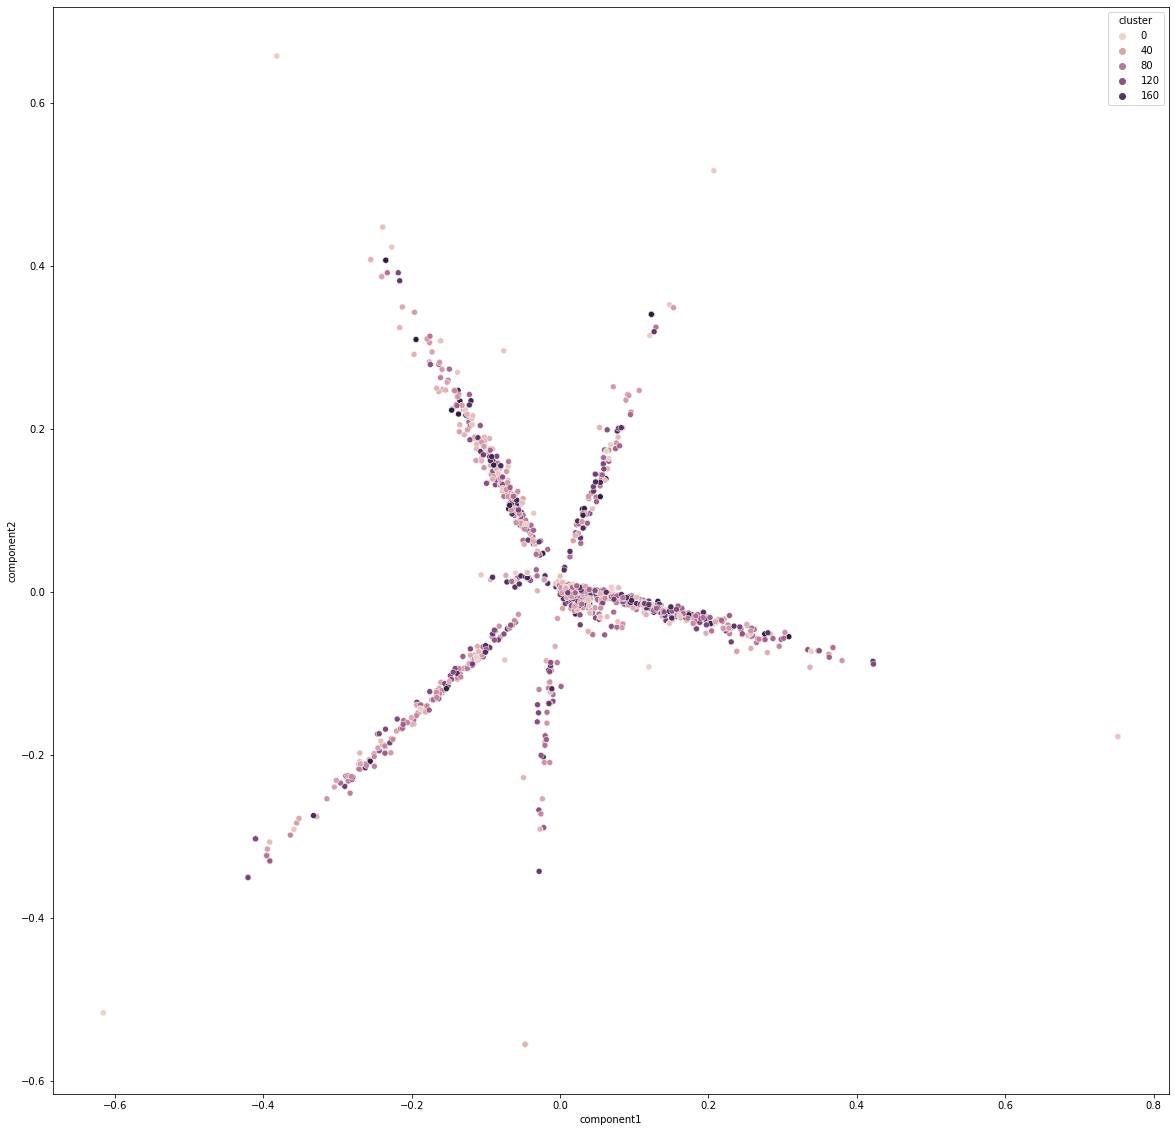

In [140]:

fig, ax = plt.subplots(figsize=(20,20))
sns.scatterplot(x=pca_components['component1'],y=pca_components['component2'], hue= pca_components['cluster'],ax=ax)


In [130]:
letter = "diabetes hypertension medical historyconcurren"
testingvac=tfidf_vectorizer.transform([letter])
test=pd.DataFrame(testingvac.toarray(), columns=tfidf_vectorizer.get_feature_names())
kmeans.predict(test) 


array([7])

In [132]:
from joblib import dump
dump(kmeans, 'my-first-kmeans_model.joblib')

['my-first-kmeans_model.joblib']